In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

In [28]:
df = pd.read_csv("data/close_adjusted_17.csv")

# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Set 'date' as index
df.set_index("date", inplace=True)

In [29]:
#Getting rid of missing values
df = df.ffill().bfill()

In [49]:
df.sum(axis=1)

date
2006-01-04    101.6228
2006-01-05    101.8815
2006-01-06    102.4781
2006-01-09    103.4165
2006-01-10    104.0141
                ...   
2023-05-19    549.0996
2023-05-22    548.6095
2023-05-23    535.9008
2023-05-24    532.7970
2023-05-25    535.4569
Length: 4378, dtype: float64

In [30]:
df = df.iloc[:, :5]

In [31]:
df.shift(1).head()

,CSCO.close,UAL.close,TROW.close,ISRG.close,PRGO.close
date,,,,,
2006-01-04,NaN,NaN,NaN,NaN,NaN
2006-01-05,12.4822,40.3514,22.5279,13.5622,12.6991
2006-01-06,12.8319,40.3514,22.5094,13.3645,12.8243
2006-01-09,13.1256,40.3514,22.6938,13.3411,12.9662
2006-01-10,13.3283,40.3514,23.0010,13.7445,12.9913


Markowitz without 1+R thing



In [32]:
log_returns = np.log(df / df.shift(1)).iloc[1:]

In [33]:
simple_returns = ((df - df.shift(1)) / df.shift(1)).iloc[1:]

In [34]:
#Markowitz using log returns
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Optimization function
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Compute mean & covariance
log_mean_returns = log_returns.mean()
log_cov_matrix = log_returns.cov()
num_assets = len(log_mean_returns)

# Constraints & bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# Optimize for minimum volatility
optimized_result = sco.minimize(minimize_volatility, initial_guess,
                                args=(log_mean_returns, log_cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# Display results
log_optimal_weights = optimized_result.x
print("Optimal Portfolio Weights:", log_optimal_weights)


Optimal Portfolio Weights: [4.79624345e-01 1.93123512e-18 4.66464108e-02 1.44048915e-01
 3.29680329e-01]


In [35]:
#Markowitz using simple returns
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

# Optimization function
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Compute mean & covariance
simple_mean_returns = simple_returns.mean()
simple_cov_matrix = simple_returns.cov()
num_assets = len(simple_mean_returns)

# Constraints & bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# Optimize for minimum volatility
optimized_result = sco.minimize(minimize_volatility, initial_guess,
                                args=(simple_mean_returns, simple_cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# Display results
optimal_weights = optimized_result.x
print("Optimal Portfolio Weights:", optimal_weights)


Optimal Portfolio Weights: [4.77414601e-01 3.46944695e-18 4.35186070e-02 1.39211905e-01
 3.39854886e-01]


From now on, everything related to simple returns wont have word simple in it. Cant say same about log.

In [36]:
simple_mean_returns = simple_returns.mean()
simple_cov_matrix = simple_returns.cov()
num_assets = len(simple_mean_returns)

In [37]:
simple_mean_returns

CSCO.close    0.000480
UAL.close     0.000881
TROW.close    0.000609
ISRG.close    0.001017
PRGO.close    0.000443
dtype: float64

EF graph using log returns

In [38]:
log_returns = log_mean_returns.values
log_risks = np.sqrt(log_cov_matrix.values.diagonal())
log_optimal_return, log_optimal_risk = portfolio_performance(log_optimal_weights, log_mean_returns, log_cov_matrix)

Same shit using simple returns

In [40]:
returns = simple_mean_returns.values
risks = np.sqrt(simple_cov_matrix.values.diagonal())
optimal_return, optimal_risk = portfolio_performance(optimal_weights, simple_mean_returns, simple_cov_matrix)

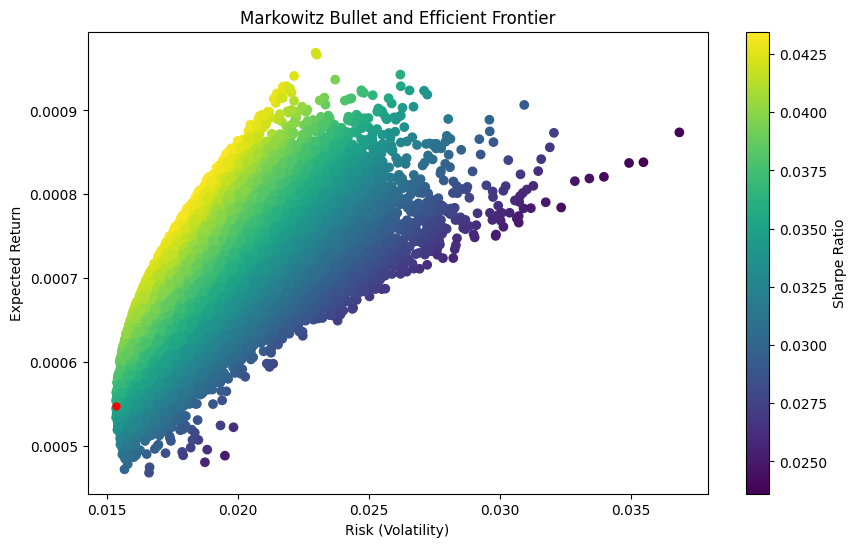

In [46]:
# num_assets
# simple_mean_returns
# simple_cov_matrix

# Generate random portfolios
num_portfolios = 50000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights

    portfolio_return = np.sum(weights * simple_mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(simple_cov_matrix, weights)))

    results[0, i] = portfolio_return
    results[1, i] = portfolio_risk
    results[2, i] = portfolio_return / portfolio_risk  # Sharpe ratio

# Plot the Markowitz Bullet
plt.figure(figsize=(10, 6))
plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o')  # Risk vs Return
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Risk (Volatility)")
plt.ylabel("Expected Return")
plt.title("Markowitz Bullet and Efficient Frontier")

plt.scatter(optimal_risk, optimal_return, c="red", s=25)

plt.show()